Off track!
Back on track!
Off track!
Back on track!
Off track!
Back on track!
Off track!
Episode 1/100, Reward: -65.48
Off track!
Back on track!
Off track!
Back on track!
Off track!
Back on track!
Off track!
Episode 2/100, Reward: -21.83
Off track!
Back on track!
Off track!
Back on track!
Off track!
Episode 3/100, Reward: -111.07
Off track!

Training interrupted by user.


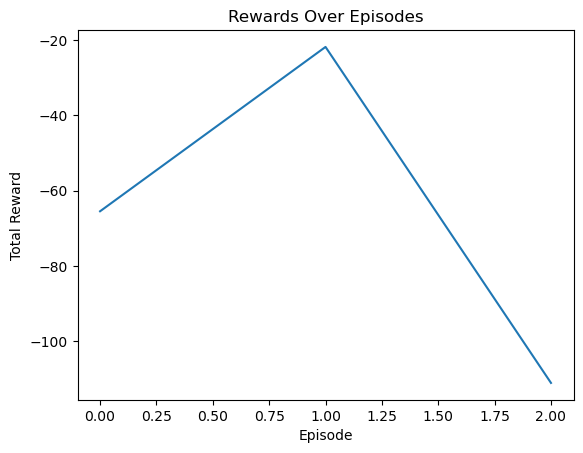

In [43]:
import numpy as np
import cv2
import gymnasium as gym
import pygame
import datetime
from collections import deque, defaultdict
import matplotlib.pyplot as plt
import warnings

# Discrete action mapping
ACTIONS = [np.array(x) for x in [
    [-1.0, 0.0, 0.0],  # hard left
    [ 0.0, 0.0, 0.0],  # no action
    [ 1.0, 0.0, 0.0],  # hard right
    [-1.0, 1.0, 0.0],  # hard left + gas
    [ 0.0, 1.0, 0.0],  # straight + gas
    [ 1.0, 1.0, 0.0],  # hard right + gas
]]

class CarRacingQL:
    def __init__(self, episodes=1000, state_bins=None, epsilon=0.4, alpha=0.1, gamma=0.9, render=True):
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        self.env = gym.make('CarRacing-v3', continuous=True, render_mode='rgb_array')
        self.actions = list(range(len(ACTIONS)))
        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma
        self.episodes = episodes
        self.render = render
        self.was_seen_on_track = True
        self.time_off_track = 0.0

        self.state_bins = state_bins or [10] * 9  # Match 9 features returned by extract_features
        self.Q_table = defaultdict(lambda: np.zeros(len(self.actions)))

        if self.render:
            pygame.init()
            self.screen = pygame.display.set_mode((640, 480))

    def auto_canny(self, image, sigma=0.33):
        v = np.median(image)
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        return cv2.Canny(image, lower, upper)

    def estimate_lane_edges(self, norm):
        vertical_profile = np.mean(norm, axis=0)
        threshold = 0.3
        indices = np.where(vertical_profile > threshold)[0]
        if len(indices) > 0:
            return indices[0] / len(vertical_profile), indices[-1] / len(vertical_profile)
        return 0.0, 1.0

    def extract_features(self, obs, obs_history, speed_history):
        car = self.env.unwrapped.car
        vel_vec = car.hull.linearVelocity
        speed = np.linalg.norm([vel_vec.x, vel_vec.y])
        wheel_steering = car.wheels[0].steer / 0.6

        speed_history.append(speed)
        acceleration = (speed_history[-1] - speed_history[-2]) * 5.0 if len(speed_history) > 1 else 0.0
        acceleration = np.clip(acceleration, -1.0, 1.0)

        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (64, 64))
        edges = self.auto_canny(resized)

        norm = resized / 255.0
        half = norm.shape[1] // 2
        left_sum, right_sum = np.sum(norm[:, :half]), np.sum(norm[:, half:])
        center_offset = (right_sum - left_sum) / (left_sum + right_sum + 1e-5)
        center_offset = np.clip(center_offset, -1.0, 1.0)

        obs_history.append(norm)
        curvature = np.mean([
            np.abs(obs_history[i] - obs_history[i - 1]).mean()
            for i in range(1, len(obs_history))
        ]) if len(obs_history) == obs_history.maxlen else 0.0
        curvature = np.clip(curvature * 5.0, 0.0, 1.0)

        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, minLineLength=20, maxLineGap=10)
        angles = [np.arctan2(y2 - y1, x2 - x1) for line in lines for x1, y1, x2, y2 in [line[0]]] if lines is not None else []
        avg_lane_angle = np.mean(angles) / np.pi if angles else 0.0

        # More robust off-track detection based on color
        car_pixels = obs[int(obs.shape[0] * 0.7):, int(obs.shape[1] * 0.4):int(obs.shape[1] * 0.6), :] / 255.0
        track_color_threshold = 0.2  # Adjust as needed
        is_on_track_likelihood = np.mean(np.linalg.norm(car_pixels - np.array([0.4, 0.4, 0.4]), axis=2) < track_color_threshold) # Assuming track is roughly gray
        off_track = 1 if is_on_track_likelihood < 0.5 else 0 # Adjust threshold as needed

        left_edge, right_edge = self.estimate_lane_edges(norm)

        return [
            center_offset,
            curvature,
            avg_lane_angle,
            min(speed / 100.0, 1.0),
            acceleration,
            float(off_track),
            np.clip(left_edge, 0.0, 1.0),
            np.clip(right_edge, 0.0, 1.0),
            np.clip(wheel_steering, -1.0, 1.0),
        ]


    def shape_reward(self, reward, obs, next_obs, features, next_features):
        shaped = reward
        is_off_track = next_features[5] == 1  # `off_track` feature is at index 5
        is_on_track = not is_off_track

        # Penalize going off track
        if is_off_track:
            if self.was_seen_on_track:
                self.time_off_track = datetime.datetime.now()
                self.was_seen_on_track = False
                shaped -= 100.0
                print("Off track!")
            else:
                shaped -= 15.0
                if self.time_off_track is not None:
                    time_spent_off_track = (datetime.datetime.now() - self.time_off_track).total_seconds()
                    shaped -= time_spent_off_track * 10.0

        if is_on_track:
            if not self.was_seen_on_track:
                self.was_seen_on_track = True
                self.time_off_track = None # Reset the timer when back on track
                shaped += 200.0
                print("Back on track!")
            else:
                # Encourage staying on track
                shaped += 15.0

        # Encourage maintaining some speed
        # shaped += next_features[3] * 2.0  # speed feature (index 3), scaled
        # penalty if too fast
        if next_features[3] > 0.8:
            shaped -= (next_features[3] - 0.8) * 10.0
        return shaped
    
    def discretize_state(self, features):
        bins = [np.linspace(-1, 1, b) for b in self.state_bins]
        return tuple(np.digitize(f, b) - 1 for f, b in zip(features, bins))

    def epsilon_greedy(self, state):
        return np.random.choice(self.actions) if np.random.rand() < self.epsilon else np.argmax(self.Q_table[state])

    def update_q_value(self, state, action, reward, next_state, done):
        max_future_q = np.max(self.Q_table[next_state])
        current_q = self.Q_table[state][action]
        target = reward if done else reward + self.gamma * max_future_q
        self.Q_table[state][action] += self.alpha * (target - current_q)

    def render_frame(self, obs):
        if self.screen is None:
            pygame.init()
            self.screen = pygame.display.set_mode((640, 400))
            pygame.display.set_caption("CarRacing Q-Learning")

        cropped = obs[:int(obs.shape[0] * 0.88), :, :]
        surf = pygame.surfarray.make_surface(cropped.swapaxes(0, 1))
        self.screen.blit(pygame.transform.scale(surf, (640, 400)), (0, 0))
        pygame.display.flip()

        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                pygame.quit()
                self.screen = None


    def skip_frames(self, skip=50):
        obs, _ = self.env.reset()
        for _ in range(skip):
            obs, _, terminated, truncated, _ = self.env.step(ACTIONS[1])  # No action
            if terminated or truncated:
                return obs, True
        return obs, False

    def run_episode(self):
        obs, done = self.skip_frames()
        obs = obs[:int(obs.shape[0] * 0.88), :, :]
        obs_history = deque(maxlen=5)
        speed_history = deque(maxlen=5)

        features = self.extract_features(obs, obs_history, speed_history)
        state = self.discretize_state(features)

        total_reward = 0.0

    
        while not done:
            action_idx = self.epsilon_greedy(state)
            next_obs, reward, terminated, truncated, _ = self.env.step(ACTIONS[action_idx])
            done = terminated or truncated

            if self.render:
                self.render_frame(next_obs)
            
            cropped = next_obs[:int(next_obs.shape[0] * 0.88), :, :]
            next_features = self.extract_features(cropped, obs_history, speed_history)
            next_state = self.discretize_state(next_features)
            shaped_reward = self.shape_reward(reward, obs, next_obs, features, next_features)
            self.update_q_value(state, action_idx, shaped_reward, next_state, done)

            features = next_features
            state = next_state
            total_reward += reward
    

        return total_reward

    def train(self):
        rewards = []
        try:
            for episode in range(1, self.episodes + 1):
                reward = self.run_episode()
                rewards.append(reward)
                print(f"Episode {episode}/{self.episodes}, Reward: {reward:.2f}")
                self.epsilon = max(0.1, self.epsilon * 0.99 ** (episode / self.episodes))
                # if episode % 100 == 0:
                #     print(f"Saving Q-table at episode {episode}")
                #     np.save("q_table.npy", dict(self.Q_table))
                self.was_seen_on_track = True
        except KeyboardInterrupt:
            print("\nTraining interrupted by user.")
        finally:
            self.close()
        return rewards


    def close(self):
        if self.render:
            pygame.quit()
        self.env.close()


if __name__ == "__main__":
    agent = CarRacingQL(episodes=100, render=True)
    rewards = agent.train()

    plt.plot(rewards)
    plt.title("Rewards Over Episodes")
    plt.xlabel("Episode")
    plt.ylabel("Total Reward")
    plt.show()

    agent.close()


In [41]:
import numpy as np
import cv2
import gymnasium as gym
import pygame
from collections import deque
import matplotlib.pyplot as plt
import warnings

# Discrete action mapping (same as before for consistency, but we'll control manually)
ACTIONS = [np.array(x) for x in [
    [-1.0, 0.0, 0.0],  # hard left
    [0.0, 0.0, 0.0],   # no action
    [1.0, 0.0, 0.0],   # hard right
    [-1.0, 1.0, 0.0],  # hard left + gas
    [0.0, 1.0, 0.0],   # straight + gas
    [1.0, 1.0, 0.0],   # hard right + gas
]]

class CarRacingManualControl:
    def __init__(self, render=True):
        warnings.filterwarnings("ignore", category=DeprecationWarning)
        self.env = gym.make('CarRacing-v3', continuous=True, render_mode='human' if render else 'rgb_array')
        self.render = render
        self.obs_history = deque(maxlen=5)
        self.speed_history = deque(maxlen=5)

    def auto_canny(self, image, sigma=0.33):
        v = np.median(image)
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        return cv2.Canny(image, lower, upper)

    def estimate_lane_edges(self, norm):
        vertical_profile = np.mean(norm, axis=0)
        threshold = 0.3
        indices = np.where(vertical_profile > threshold)[0]
        if len(indices) > 0:
            return indices[0] / len(vertical_profile), indices[-1] / len(vertical_profile)
        return 0.0, 1.0

    def extract_features(self, obs):
        car = self.env.unwrapped.car
        vel_vec = car.hull.linearVelocity
        speed = np.linalg.norm([vel_vec.x, vel_vec.y])
        wheel_steering = car.wheels[0].steer / 0.6

        self.speed_history.append(speed)
        acceleration = (self.speed_history[-1] - self.speed_history[-2]) * 5.0 if len(self.speed_history) > 1 else 0.0
        acceleration = np.clip(acceleration, -1.0, 1.0)

        gray = cv2.cvtColor(obs, cv2.COLOR_RGB2GRAY)
        resized = cv2.resize(gray, (64, 64))
        edges = self.auto_canny(resized)

        norm = resized / 255.0
        half = norm.shape[1] // 2
        left_sum, right_sum = np.sum(norm[:, :half]), np.sum(norm[:, half:])
        center_offset = (right_sum - left_sum) / (left_sum + right_sum + 1e-5)
        center_offset = np.clip(center_offset, -1.0, 1.0)

        self.obs_history.append(norm)
        curvature = np.mean([
            np.abs(self.obs_history[i] - self.obs_history[i - 1]).mean()
            for i in range(1, len(self.obs_history))
        ]) if len(self.obs_history) == self.obs_history.maxlen else 0.0
        curvature = np.clip(curvature * 5.0, 0.0, 1.0)

        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 30, minLineLength=20, maxLineGap=10)
        angles = [np.arctan2(y2 - y1, x2 - x1) for line in lines for x1, y1, x2, y2 in [line[0]]] if lines is not None else []
        avg_lane_angle = np.mean(angles) / np.pi if angles else 0.0

        # More robust off-track detection based on color
        car_pixels = obs[int(obs.shape[0] * 0.7):, int(obs.shape[1] * 0.4):int(obs.shape[1] * 0.6), :] / 255.0
        track_color_threshold = 0.2  # Adjust as needed
        is_on_track_likelihood = np.mean(np.linalg.norm(car_pixels - np.array([0.4, 0.4, 0.4]), axis=2) < track_color_threshold) # Assuming track is roughly gray
        off_track = 1 if is_on_track_likelihood < 0.5 else 0 # Adjust threshold as needed

        left_edge, right_edge = self.estimate_lane_edges(norm)

        return [
            center_offset,
            curvature,
            avg_lane_angle,
            min(speed / 100.0, 1.0),
            acceleration,
            float(off_track),
            np.clip(left_edge, 0.0, 1.0),
            np.clip(right_edge, 0.0, 1.0),
            np.clip(wheel_steering, -1.0, 1.0),
        ]

    def reset_environment(self):
        obs, _ = self.env.reset()
        self.obs_history.clear()
        self.speed_history.clear()
        return obs[:int(obs.shape[0] * 0.88), :, :]

    def process_action(self, action):
        obs, reward, terminated, truncated, _ = self.env.step(action)
        return obs[:int(obs.shape[0] * 0.88), :, :], reward, terminated, truncated

    def close(self):
        self.env.close()

if __name__ == "__main__":
    manual_control = CarRacingManualControl(render=True)
    obs = manual_control.reset_environment()

    print("Instructions:")
    print("Use arrow keys for steering (left/right).")
    print("Press 'up' for gas, 'down' for brake (not implemented in discrete actions).")
    print("Press 'space' for no action.")
    print("Close the Pygame window to exit.")

    pygame.init()
    screen = pygame.display.set_mode((640, 400))
    pygame.display.set_caption("CarRacing Manual Control - Checking Features")
    font = pygame.font.Font(None, 30)

    running = True
    while running:
        for event in pygame.event.get():
            if event.type == pygame.QUIT:
                running = False
                break
            if event.type == pygame.KEYDOWN:
                action = np.array([0.0, 0.0, 0.0])  # Default no action
                if event.key == pygame.K_LEFT:
                    action = ACTIONS[0]  # Hard left
                elif event.key == pygame.K_RIGHT:
                    action = ACTIONS[2]  # Hard right
                elif event.key == pygame.K_UP:
                    action = ACTIONS[4]  # Straight + gas
                elif event.key == pygame.K_DOWN:
                    action = np.array([0.0, -1.0, 0.0]) # Brake (continuous, not in discrete)
                elif event.key == pygame.K_SPACE:
                    action = ACTIONS[1]  # No action

                next_obs, reward, terminated, truncated = manual_control.process_action(action)
                obs = next_obs

                features = manual_control.extract_features(obs) # Extract features here

                print("\nExtracted Features:")
                print(f"  Center Offset: {features[0]:.3f}")
                print(f"  Curvature:     {features[1]:.3f}")
                print(f"  Avg Lane Angle:{features[2]:.3f}")
                print(f"  Speed:         {features[3]:.3f}")
                print(f"  Acceleration:  {features[4]:.3f}")
                print(f"  Off Track:     {features[5]:.3f}")
                print(f"  Left Edge:     {features[6]:.3f}")
                print(f"  Right Edge:    {features[7]:.3f}")
                print(f"  Wheel Steering:{features[8]:.3f}")
                print(f"  Reward:        {reward:.2f}")
                print(f"  Terminated:    {terminated}")
                print(f"  Truncated:     {truncated}")

                if terminated or truncated:
                    obs = manual_control.reset_environment()

        # Render the game frame
        game_frame = obs.swapaxes(0, 1)
        pygame_frame = pygame.surfarray.make_surface(game_frame)
        screen.blit(pygame.transform.scale(pygame_frame, (640, 400)), (0, 0))

        # Display the features on the screen
        if 'features' in locals(): # Only display if features have been extracted
            y_offset = 10
            for i, feature in enumerate(features):
                text_surface = font.render(f"{['Center Offset', 'Curvature', 'Avg Lane Angle', 'Speed', 'Acceleration', 'Off Track', 'Left Edge', 'Right Edge', 'Wheel Steering'][i]}: {feature:.3f}", True, (255, 255, 255))
                screen.blit(text_surface, (10, 400 + y_offset))
                y_offset += 20

        pygame.display.flip()

    manual_control.close()
    pygame.quit()

Instructions:
Use arrow keys for steering (left/right).
Press 'up' for gas, 'down' for brake (not implemented in discrete actions).
Press 'space' for no action.
Close the Pygame window to exit.

Extracted Features:
  Center Offset: -0.585
  Curvature:     0.000
  Avg Lane Angle:0.215
  Speed:         0.022
  Acceleration:  0.000
  Off Track:     1.000
  Left Edge:     0.000
  Right Edge:    0.609
  Wheel Steering:-0.000
  Reward:        7.45
  Terminated:    False
  Truncated:     False

Extracted Features:
  Center Offset: -0.513
  Curvature:     0.000
  Avg Lane Angle:0.482
  Speed:         0.034
  Acceleration:  1.000
  Off Track:     1.000
  Left Edge:     0.000
  Right Edge:    0.641
  Wheel Steering:-0.000
  Reward:        -0.10
  Terminated:    False
  Truncated:     False

Extracted Features:
  Center Offset: -0.446
  Curvature:     0.000
  Avg Lane Angle:0.485
  Speed:         0.044
  Acceleration:  1.000
  Off Track:     1.000
  Left Edge:     0.000
  Right Edge:    0.672
  W